<a href="https://colab.research.google.com/github/liuzyon/ACSE-8-colab/blob/main/practical_3/Morning_Session_3_MNIST_Neural_Networks_Regularization_Cross_Validation_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Notebook modified from the original version by `Lukas Mosser` and `Navjot Kukreja`

In [ ]:
!pip install pycm livelossplot
%pylab inline

# ACSE Module 8 - Practical - Morning Session 3:
----
# Training Deep Neural Networks - Cross-Validation

###Objectives of today's session:

- Design a fully connected feed forward neural network for MNIST
- Create a validation split and normalise it
- Perform a manual grid search on the momentum parameters
- Combine validation and training set once we have optimal momentum parameters and train the model again
- Run the test dataset and report accuracy
- Generate some of the plots we saw in the theory lectures to analyse performance

<br>

On Practical 2, we learned how to **train network parameters** using backpropagation. Today we will learn how to choose **hyperparameters**:

<img src="https://miro.medium.com/max/2140/1*pR6bSQXgC1Y_lYTeLDqVqg.png" alt="network" width="600"/>

#### A few imports before we get started

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


# Important concepts from Practicall session 2 revisited:

- **Recap 1**: `nn.Module` as a tool to define neural networks

We use the `nn.Module` class to define our network:

In [ ]:
# pseudo-code, don't try to run it!

class DummyNetwork(nn.Module): #继承nn.Module类
    def __init__(self):
        super(DummyNetwork, self).__init__()
        # define your layers and activations
        
    def forward(self, x):
        # define your network forward pass
        # return output of the network

- **Recap 2**: training loop structure

Training loop structure is always of the form (with variations, of course):

In [ ]:
# pseudo-code, don't try to run it!

model = DummyNetwork()                                    # get an instance of your network 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # define an optimiser (SGC, Adam, etc)
criterion = torch.nn.MSELoss()                            # define your loss function
model.train()                                             # tell the model we are going to train
    for X, y in data_loader:                              # iterate over epochs
        optimizer.zero_grad()                             # reset gradients
        output = model(X)          # forward propagtion through the model
        loss = criterion(y, output)    # compute loss
        loss.backward()            # backpropagate
        optimizer.step()           # update model parameters using the gradients

- **Recap 3**: `Dataset` and `Dataloader`

[`Datasets` and `Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) tutorial.

[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) : an abstract class representing a dataset. <br>
[`Dataloader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader):  provides an iterable over the given dataset.

- **Additional reads**: Computational graphs (**not required**)

A good explanation of [computational graphs and autodifferentiation](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/)

---

## Task 1: Training a deep neural network on MNIST using Pytorch

In this exercise we will use cross-validation to estimate the hyperparameters of a deep-neural network trained on the MNIST dataset and create predictions on the MNIST datasets public test set.（在这个练习中，我们将使用交叉验证来估计在MNIST数据集上训练的深度神经网络的超参数，并在MNIST数据集公共测试集上创建预测。）

## 1.1: Mounting the google drive for later storage

In [52]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 1.2: The MNIST Dataset - Hello World of Deep-Learning

In [53]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

## 1.3: Instantiate and create a ```StratifiedShuffleSplit``` generator using sklearn.
1. Create a ```sklearn.model_selection.StratifiedShuffleSplit``` object with 1-split and a test-size of 10%.
2. Get the training and validation indices from the shuffle-split

[`StratifiedShuffleSplit` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) (+ a trick to embed a website in notebooks for easy access while coding)

In [19]:
%%html
<iframe src="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html" width="1200" height="300">
</iframe>

In [57]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.data, mnist_train.targets) # n_splits=1 只产生一个训练集/验证集对
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
print('indices type: ', type(indices))
print('indices: ', indices) #训练集和验证集的indices (一个元组，第一个元素为训练集的indices，第二个元素为验证集的indices)
print('mnist_train type: ', type(mnist_train))
print('mnist_train.data type: ', type(mnist_train.data))
print('mnist_train.targets type: ', type(mnist_train.targets))
print('mnist_train.targets size: ', mnist_train.targets.size()) #训练集为60000个
print('mnist_train targets: ', mnist_train.targets)
print('pixel value of one mnist_train image: ', mnist_train.data[0][14][14].item()) #一个mnist_train图像（即一个训练样本）的一个像素值

indices type:  <class 'tuple'>
indices:  (array([50700, 15345,  2527, ...,  4176, 14834, 39484]), array([58886, 22875, 48551, ..., 13829, 40340, 38131]))
mnist_train type:  <class 'torchvision.datasets.mnist.MNIST'>
mnist_train.data type:  <class 'torch.Tensor'>
mnist_train.targets type:  <class 'torch.Tensor'>
mnist_train.targets size:  torch.Size([60000])
mnist_train targets:  tensor([5, 0, 4,  ..., 5, 6, 8])
pixel value of one mnist_train image:  240


## 1.4 `code along`: Split and standardise the data（对数据进行分割和标准化）
The original mnist data is given in gray-scale values between 0 and 255.
You will need to write a normalisation method that takes in a ```torch.Tensor``` and performs normalisation.（原始mnist数据的灰度值在0到255之间。您需要编写一个接收```torch.Tensor```的规范化方法和执行标准化）
The mean of MNIST is 0.1307 and it's standard deviation is 0.3081 (after division by 255). We could have computed these values using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) function in sklearn, but since they are provided here, use them directly.


In [21]:
def apply_normalization(X):
  X /= 255. ## normalize pixel values to the range 0 to 1. Pixel values are often unsigned integers in the range between 0 and 255.
  X -= 0.1307 ## mean of the pixel values in this data set is 0.1307（该均值为除以255后的）
  X /= 0.3081 ## variance of the pixel values in this dataset is 0.3081（该方差为除以255后的）
  return X

Use the indices computed above and normalise the data（使用上述计算的索引，并将数据标准化）:

In [22]:
X_train, y_train = apply_normalization(mnist_train.data[indices[0]].float()), mnist_train.targets[indices[0]] # index is 0 because that's how we defined the indices above 训练集样本的indices为indices[0]
X_val, y_val = apply_normalization(mnist_train.data[indices[1]].float()), mnist_train.targets[indices[1]]     # index is 1 because that's how we defined the indices above  验证集样本的indices为indices[1]
X_test, y_test =  apply_normalization(mnist_test.data.float()), mnist_test.targets                            # test dataset

## 1.5: Instantiate a ```torch.utils.data.TensorDataset``` for training, validation and test data （为训练数据，验证数据，测试数据实例化TensorDataset）

Remember from last session, we use `TensorDataset` to reduce the memory footprint and have a convenient way to access large datasets stored on disk.

In [23]:
# TensorDataset()类可以直接把数据变成pytorch的DataLoader()可使用的数据
mnist_train = TensorDataset(X_train, y_train.long())    # PyTorch wants longs for categorical data
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

Let's visualise an example of the images and check whether the data is normalised properly (compute .mean() and .std() on the training set.)

0.00011968147737206891 1.000293493270874


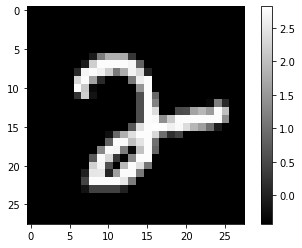

In [24]:
plt.imshow(X_train[0], cmap=cm.gray)
plt.colorbar()
print(X_train.mean().item(), X_train.std().item())

And let's plot a few more:

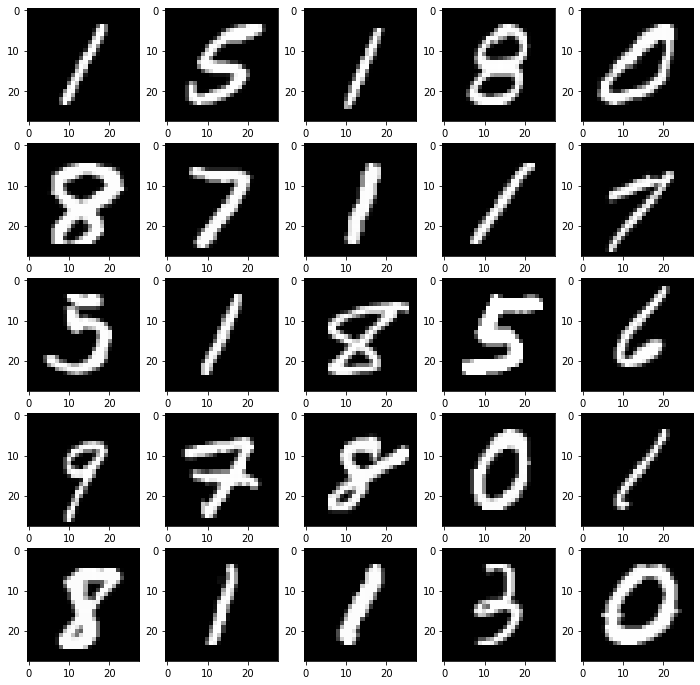

In [25]:
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i], cmap=cm.gray)
plt.show()

## 1.6 `code along`: Create a SimpleNet as a ```nn.Module``` （使用```nn.Module```创建一个简单的网络）
Create a simple feed-forward neural network with the following architecture:
- Input Layer: 28*28 neurons
- Hidden Layer: 25 neurons
- Output Layer: 10 neurons
- Hidden Layer Activation: ReLU
- Output Layer Activation: None

Which ones of these parameters are dictated by the nature of the dataset? （输出层神经元，输出层神经元）<br>
What are these values we defined above?


In [26]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__() #调用父类的构造方法
        self.linear_1 = nn.Linear(28*28, 25) # use nn.Linear and nn.Relu to define your layers and activations 定义第一层（28*28到25的映射，从输入层到隐藏层）
        self.linear_2 = nn.Linear(25, 10) # 定义第二层（25到10的映射，从隐藏层到输出层）
        self.activation = nn.ReLU() # 定义激活函数        
        
    def forward(self, x):
        z1 = self.linear_1(x)               # code your forward pass using the layers and activations above
        a1 = self.activation(z1)
        z2 = self.linear_2(a1)
        return z2                          # return z2 (not a2, we will see this later) 注意，这里返回的是z2，而不是a2
        # return x
        # return z1
        # return a1

[`nn.Linear` documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) <br>
[`nn.ReLu` documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

Let's check the input, hidden, and output sizes.

What happens if we comment out parts or of all the forward function?

In [27]:
set_seed(42) # what does the setting the seed does here? 设置随机种子，使得每次随机结果相同
model = SimpleNet()
# print(X_train[0].shape)
X_ = X_train[0].view(-1,28*28) # 返回一个新的张量，其数据与自张量相同，但形状不同
# print(X_.shape)
y_ = model(X_)
print(y_.shape,y_.max())#.item())

torch.Size([1, 10]) tensor(0.3337, grad_fn=<MaxBackward1>)


The `torch.view` function is similar to `torch.reshape` in PyTorch. But since `torch.reshape` behaves a bit erratically in terms of copying or providing a view of the tensor, we will always use `torch.view`. You can find a good explanation of the differences [here](https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch)

## 1.7: Sanity checks on our SimpleNet(SimpleNet上的完整性检查)


In [28]:
set_seed(42) # what does the setting the seed does here?
model = SimpleNet().to(device) ## .to(device) loads the model on the device, i.e GPUs in this example
criterion = nn.CrossEntropyLoss() # change to NLLLoss if you want to keep the softmax in the module (network)

X_ = X_train[0].view(-1, 28*28).to(device)  ## get 1 sample only. Also .view(-1,28*28) reshapes the tensor to get it ready for the first fully connected layer. 
## the dimension of -1 implies that the actual value for this dimension will be inferred so that the number of elements in the view matches the original number of elements.(维数为-1意味着将推断出该维数的实际值，以便视图中的元素数量与原始元素数量匹配)

y_ = torch.zeros((1)).to(device).long().to(device) # loads the tensor to the current device in use, i.e the GPUs
a2 = model(X_) ## a2 = z2 in this case since SimpleNet is returning z2
loss = criterion(a2, y_) ## the loss criterion CrossEntropyLoss(), combines nn.LogSoftMax and nn.NLLLoss so it is essentially computing the loss between the non_linear transform of z2 and the label y_
y_pred = F.log_softmax(a2, dim=1).max(1)[1] ## gives the predicted value as the maximum probability value index based on the log_softmax operation on a2 
# 对a2（这里model返回的是z2，因此a2=z2）进行softmax操作选出最大概率的index作为预测值，max里这里参数1为维度，后面的1表示为tensor的第二个参数，代表索引值index

print(F.log_softmax(a2, dim=1))
print('prediction:                                 ', y_pred.item())
print('true value (we force it to be zero above!): ', y_.item())

tensor([[-2.3002, -2.2015, -2.3132, -2.7334, -2.3650, -2.3482, -2.2407, -2.1243,
         -2.6117, -1.9923]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
prediction:                                  9
true value (we force it to be zero above!):  0


Note that we have left the last activation out of our network. This is because PyTorch's [`CrossEntropyLoos`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) already includes a [`LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) operation. 注意我们将最后一层的激活函数没有定义在我们的网络之内。这是因为PyTorch's `CrossEntropyLoos` 已经包括了一个`LogSoftmax`操作

## 1.8 `code along`: Create simple train function（创建简单的训练函数）

The function should perform the following tasks:
1. Set the model into training mode
2. Iterate over all the mini-batches（迭代所有的小批量）
3. Send the batches to the GPU / CPU
4. Zero all the gradients
5. Perform the forward-pass
6. Compute the loss
7. Perform the backward-pass
8. Keep a running measure of training loss and accuracy
9. Perform a step of gradient-descent
10. Once done with all batches, return average training loss and accuracy（一旦完成所有批量，返回平均训练损失和准确性）

In [29]:
def train(model, optimizer, criterion, data_loader):
    model.train()                         # the model is in the training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy = 0, 0     # initialise loss and accuracy to 0 for training
    for X, y in data_loader:              # iterate over the mini-batches defined in the data loader 迭代所有的小批量，这里根据下面参数为每次迭代的为一个batch
        X, y = X.to(device), y.to(device) # send data to the device (GPU in our case)
        optimizer.zero_grad()             # resetting optimiser info 每次backward之前要重置梯度，否则之后backward计算的梯度会累积到之前backward的结果之上
        a2 = model(X.view(-1, 28*28))     # forward pass
        loss = criterion(a2, y)           # compute loss
        loss.backward()                   # backpropagation to calculate the gradients 如果你做完运算后使用tensor.backward()，所有的梯度就会自动运算，tensor的梯度将会累加到它的.grad属性里面去
        train_loss += loss*X.size(0)      # # add it up for different mini-batches and undo loss normalisation 对不同的小批量将他们loss加起来
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy 计算准确度，并将该小批量的准确度加到总训练准确度上
        optimizer.step()                  # perform a step of gradient descent 执行一次优化步骤，通过梯度下降法来更新参数的值
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset 这里我们可以对整个数据集求损失和准确度，即累加了一个epoch的batch损失和准确度，然后根据batch数量求平均值

## 1.9 `code along`: Create simple validate function（创建验证函数）

The function should perform the following tasks:
1. Set the model into evaluation mode
2. Iterate over all the mini-batches
3. Send the batches to the GPU / CPU
5. Perform the forward-pass
6. Compute the loss
8. Keep a running measure of validation loss and accuracy
10. Once done with all batches, return average validation loss and accuracy

In [30]:
def validate(model, criterion, data_loader):      # does not need optimiser
    model.eval()                                  # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0 for training
    for X, y in data_loader:                      # iterate over the mini-batches defined in the data loader
        with torch.no_grad():                     # deactivates autograd engine 关闭自动梯度引擎
            X, y = X.to(device), y.to(device)     # send data to the device (GPU in our case)
            a2 = model(X.view(-1, 28*28))         # forward pass
            loss = criterion(a2, y)               # evaluate loss
            validation_loss += loss*X.size(0)     # add it up for different mini-batches and undo loss normalisation
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset 这里我们可以对整个数据集求损失和准确度，即一个epoch里一个batch的平均损失和准确度

 ## 1.10: Set the hyperparameters of your model
- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training, but affects validation times): 1000
- Shuffle the training set every epoch: Yes

In [31]:
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

## 1.11 `code along`: Instantiate our model, optimizer and loss function
Set the random number generator seed using ```set_seed``` to make everything reproducible.
As a criterion use a sensible loss for the multi-class classification problem.

In [33]:
set_seed(seed)
model = SimpleNet().to(device)                                              # instantiate model and send it to the GPU
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)   # instantiate the optimizer
criterion = nn.CrossEntropyLoss()                                           # define the loss

## 1.12: Create dataloaders for the training, validation and test data

In [35]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data. 每一个batch大小为64，shuffle设置为true，即在每一个epoch都对数据进行重洗
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

Do you know what `shuffle` do? Why do we use it here?

If num_workers=2 for example, 2 other workers will put data into the RAM instead of the main process. Good discussion about how to choose it [here](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/5) (**not required**)

## 1.13: Perform the training of the network and validation
Here we provide you with a method to visualize both training and validation loss while training your networks using [livelossplot](https://github.com/stared/livelossplot). （在这里，当训练您的网络，我们为您提供 livelossplot 来可视化训练和验证损失）

As the repo says: *Don't train deep learning models blindfolded! Be impatient and look at each epoch of your training!*（正如repo所说:不要蒙着眼睛训练深度学习模型!耐心一点，看看你训练的每个阶段）

With this method we will be able to generate the plots Olivier shoed in his slides:

<img src="https://raw.githubusercontent.com/acse-2020/ACSE-8/main/implementation/practical_3/Figs/UsingValidationDuringTraining.png?token=ABNZJPZVFB6UI7ZOUPR5BB3ATFFSW" width=600/>

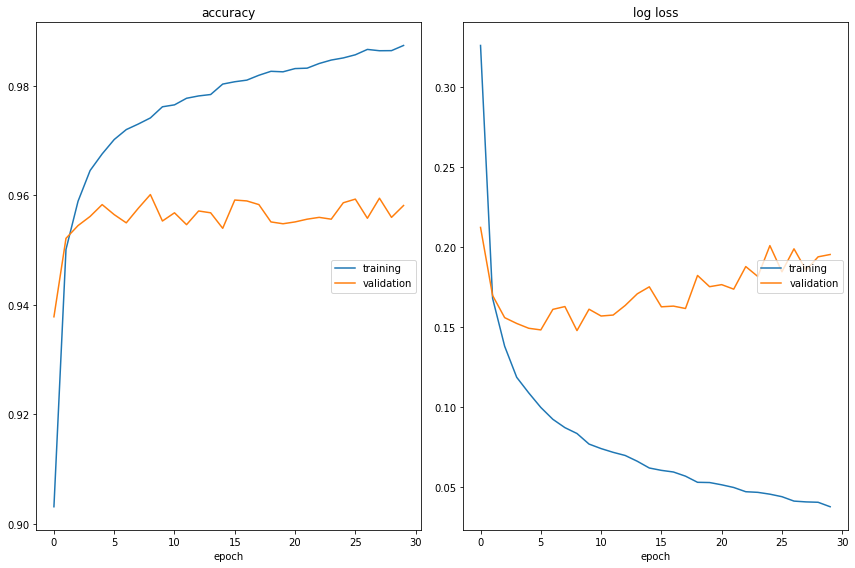

accuracy
	training         	 (min:    0.903, max:    0.987, cur:    0.987)
	validation       	 (min:    0.938, max:    0.960, cur:    0.958)
log loss
	training         	 (min:    0.038, max:    0.326, cur:    0.038)
	validation       	 (min:    0.148, max:    0.212, cur:    0.196)
0.19556595385074615


In [36]:
set_seed(seed)
liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(30): #迭代30代
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

It seems the model isn't doing very well. Let's optimise a hyperparameter to see if we can do any better.(看起来这个模型运行得不是很好。让我们优化一个超参数，看看是否能做得更好)

## 1.14 `code along`: Running a grid-search
We will run a grid search over the momentum value using the following: `momentum = [0.1, 0.5, 0.9]`
to figure out the 'best' value of momentum.（通过网格搜索，从这三个值中选出一个最好的momentum值）

In [37]:
def train_model(momentum):          # define function train_momentum which accepts one argument (momentum)
  set_seed(seed)                    # set seed
  model = SimpleNet().to(device)    # instantiate model and send it to the GPU
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)  # define an optimiser
  criterion = nn.CrossEntropyLoss() # define the loss function
  
  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)               # train_loader
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0) # validation_loader
  test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)           # test_loader
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['log loss'] = train_loss.item()
      logs['accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_log loss'] = validation_loss.item()
      logs['val_accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return True

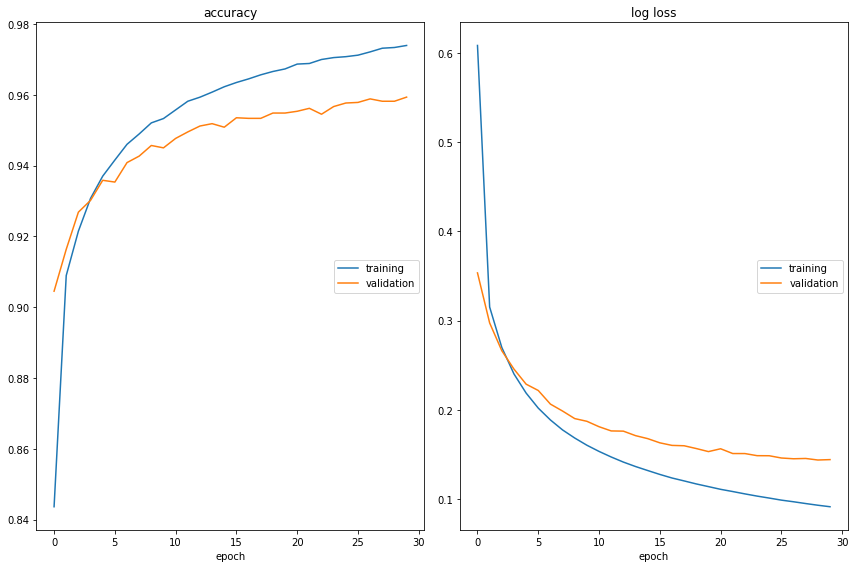

accuracy
	training         	 (min:    0.844, max:    0.974, cur:    0.974)
	validation       	 (min:    0.904, max:    0.959, cur:    0.959)
log loss
	training         	 (min:    0.091, max:    0.608, cur:    0.091)
	validation       	 (min:    0.144, max:    0.353, cur:    0.144)


True

In [38]:
train_model(0.1)

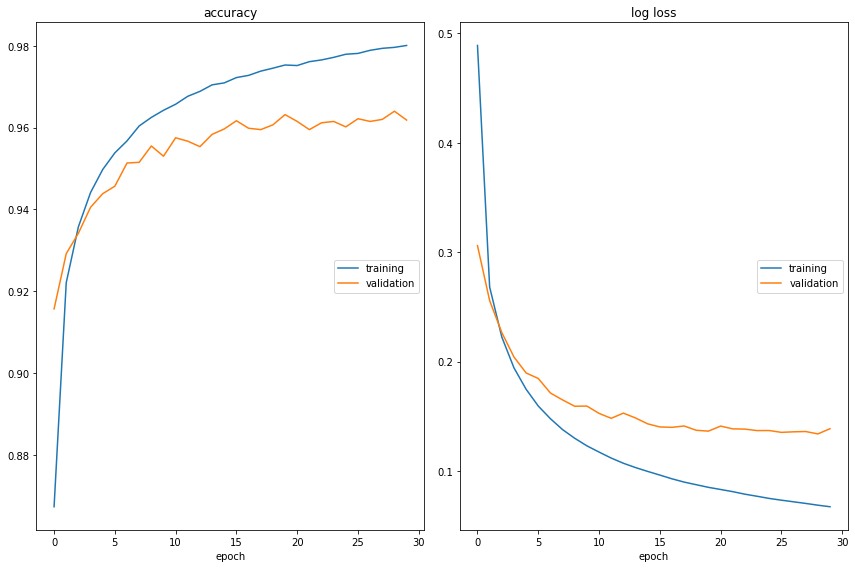

accuracy
	training         	 (min:    0.867, max:    0.980, cur:    0.980)
	validation       	 (min:    0.916, max:    0.964, cur:    0.962)
log loss
	training         	 (min:    0.067, max:    0.489, cur:    0.067)
	validation       	 (min:    0.134, max:    0.306, cur:    0.139)


True

In [39]:
train_model(0.5)

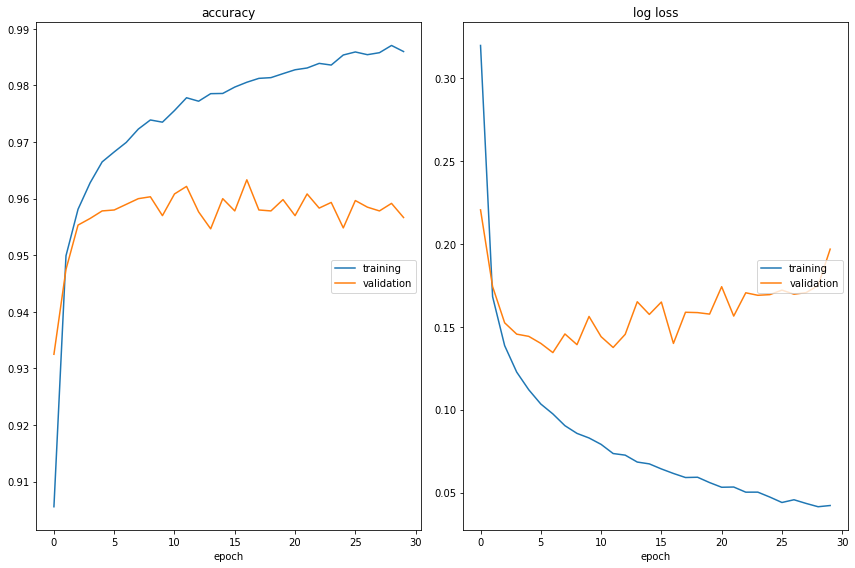

accuracy
	training         	 (min:    0.906, max:    0.987, cur:    0.986)
	validation       	 (min:    0.932, max:    0.963, cur:    0.957)
log loss
	training         	 (min:    0.041, max:    0.320, cur:    0.042)
	validation       	 (min:    0.134, max:    0.221, cur:    0.197)


True

In [40]:
train_model(0.9)

In [41]:
best_momentum = 0.5

## 1.15: Implement an evaluate method
This method performs the same as validate but doesn't report losses, but simply returns all predictions on a given dataset (training, validation, test-set)（此方法执行与验证相同的操作，但不报告损失，而是简单地返回给定数据集(训练、验证、测试集)的所有预测）

In [42]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 28*28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
    
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0) ## concatenate the labels of each batch into a single list

y_pred, y_gt = evaluate(model, validation_loader)
print(y_pred, y_gt) # y_pred:预测值 y_gt:实际值

[1 9 3 ... 5 0 4] [1 9 3 ... 5 0 4]


## 1.17: Plotting a confusion matrix(绘制混淆矩阵)

We can use a confusion matrix to diagnose problems in our models.
What numbers are missclassified more often?

(To generate the confusion matrix we use the [PyCM library](https://www.pycm.ir/doc/index.html))

In [43]:
cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred) ## Create the confusion matrix from Data. ConfusionMatrix is a class derived from the pycm library
print(cm)
## the rows of the confusion matrix give the number of the instances in the actual class that were wrongly predicted.

Predict   0         1         2         3         4         5         6         7         8         9         
Actual
0         572       1         0         0         3         7         3         1         5         0         

1         0         666       4         1         1         0         0         0         1         1         

2         3         10        557       7         1         0         5         6         6         1         

3         0         0         6         580       2         9         0         2         7         7         

4         1         2         3         0         569       1         0         3         0         5         

5         2         1         0         3         2         522       3         1         6         2         

6         4         1         0         1         6         3         574       1         2         0         

7         0         6         4         2         4         1         0         598       0       

/usr/local/lib/python3.7/dist-packages/pycm/pycm_obj.py:195: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


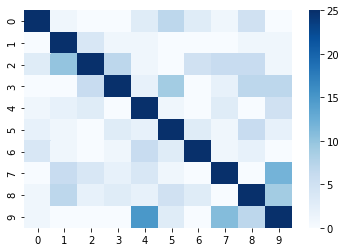

In [44]:
import seaborn as sns

def to_raw_matrix(cm):
    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    return plt_cm

rcm = to_raw_matrix(cm) #store the confusion matrix values

sns.heatmap(rcm, cmap="Blues", vmin=0, vmax=25)

## 1.18: Given that you estimated your hyperparameters, train your model on the full dataset and evaluate on the test set(考虑到您估计了超参数，要在完整的数据集上训练您的模型，并在测试集上进行评估)

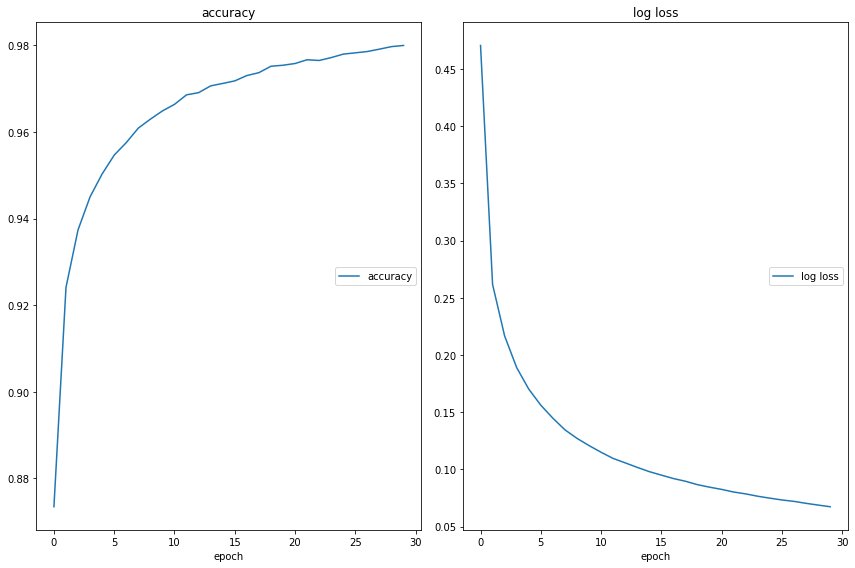

accuracy
	accuracy         	 (min:    0.873, max:    0.980, cur:    0.980)
log loss
	log loss         	 (min:    0.067, max:    0.471, cur:    0.067)
Avg. Test Loss: 0.112  Avg. Test Accuracy: 0.967



In [45]:
mnist_train = MNIST("./", download=True, train=True)

X_train, y_train = apply_normalization(mnist_train.train_data.float()), mnist_train.train_labels #获得训练数据
mnist_train = TensorDataset(X_train, y_train) #定义训练数据集
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)  # now we define 4 workers to load the mini-batches 即四个进程去加载数据 定义训练集加载器

set_seed(seed) #设置随机种子
model = SimpleNet().to(device)  #定义神经网络并放到GPU上
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=best_momentum)  #定义优化器
criterion = nn.CrossEntropyLoss() #定义损失函数

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['log loss'] = train_loss.item()
    logs['accuracy'] = train_accuracy.item()

    # test_loss, test_accuracy = validate(model, criterion, test_loader)
    # logs['val_' + 'log loss'] = test_loss.item()
    # logs['val_' + 'accuracy'] = test_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)    # first time we use the test dataset!
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

## 2.1: Storing and loading models - Pytorch State-Dicts

Pytorch stores all the parameters of models and optimizers, their weights and biases in an easy to read dictionary called a "state-dict".
When we store models and optimizers, we store the state-dict.  (Pytorch将模型和优化器的所有参数、权重和偏差存储在一个易于阅读的字典中，称为“状态-字典”。当我们存储模型和优化器时，我们存储状态-字典。)
Together with the model definition we can then restore the model to it's state when we stored it to disk.
Let's look at the contents of the state-dict of both our optimizer and our model:(我们将模型存储到磁盘时，我们可以将模型与模型定义一起恢复到它的状态。让我们看看优化器和模型的状态字典的内容)

In [46]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

## print(model) can also be used to print-out the layers of the model sequentially. However, this does not produce a visualization.

Model's state_dict:
linear_1.weight 	 torch.Size([25, 784])
linear_1.bias 	 torch.Size([25])
linear_2.weight 	 torch.Size([10, 25])
linear_2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[ 0.0029,  0.0029,  0.0029,  ...,  0.0029,  0.0029,  0.0029],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        [-0.0025, -0.0025, -0.0025,  ..., -0.0025, -0.0025, -0.0025],
        ...,
        [ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  0.0014],
        [ 0.0031,  0.0031,  0.0031,  ...,  0.0031,  0.0031,  0.0031],
        [-0.0026, -0.0026, -0.0026,  ..., -0.0026, -0.0026, -0.0026]],
       device='cuda:0')}, 1: {'momentum_buffer': tensor([-0.0067, -0.0019,  0.0059,  0.0158, -0.0059, -0.0052, -0.0022, -0.0075,
        -0.0048, -0.0037, -0.0026,  0.0013,  0.0082, -0.0200,  0.0164, -0.0076,
        -0.0091,  0.0141, -0.0088,  0.0172,  0.0025, -0.0182, -0.0032, -0.0073,
         0.0061], device='cuda:0')}, 2: {'momentum_buffe

## 2.2: Storing models to disk
From colab (and locally) we can store models to disk using ```torch.save``` and passing both a models state_dict() and a path where to store it.

In [48]:
#!mkdir '/content/gdrive/My Drive/models'  ## create the director for storing the model

model_save_name = 'simplenet_mnist_classifier.pt' ## .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

optimiser_save_name = 'simplenet_mnist_classifier_optimiser.pt' ## .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{optimiser_save_name}" 
torch.save(model.state_dict(), path)

## 2.3: Loading models from checkpoints
Finally, we can restore models from the saved ```state_dict```'s and do a number of things such as:(最后，我们可以从保存的state_dict中恢复模型，并做一些事情，例如)
1. Continue training (given we stored the optimizer as well)
2. Make predictions from our model
3. Perform inspections of our model
4. Use our model in ensembles 
5. ...

By default a loaded model is put into ```.train()``` mode. So be careful when using networks that behave different depending on training and test time e.g. dropout regularized networks or batch-normalized networks.

In [49]:
model = SimpleNet().to(device) ## creates an instance of the model
model.load_state_dict(torch.load(path)) ## loads the parameters of the model in path. state_dict is a dictionary object that maps each layer in the model to its trainable parameters (weights and biases).
model.eval()

test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Avg. Test Loss: 0.112  Avg. Test Accuracy: 0.967



We had this before: Avg. Test Loss: 0.112  Avg. Test Accuracy: 0.967

Our model performs exactly the same as before storing it to disk.

[Here](https://pytorch.org/tutorials/beginner/saving_loading_models.html) you can find a document with a more in-depth description on how to save and load PyTorch models

---

#Summary of the day:

- First network designed to work on MNIST.
- `StratifiedShuffleSplit` class generates a validation set.(`StratifiedShuffleSplit` 类生成一个验证集)
- Hyperparameter optimisation (momentum in today's lecture, but the same concept can be extended to any hyperparameter) with a manual grid search.
- Improve performance by retraining full dataset (training + validation) with optimal hyperparameter derived from cross-validation.
- Confusion matrix as a tool to better understand the limitations of our models.
- Save and load Pytorch models.